In [11]:
!pip install ludwig
!pip install ptitprince


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 8.2 MB/s eta 0:00:00
  Created wheel for ptitprince: filename=ptitprince-0.2.7-py3-none-any.whl size=10655 sha256=9e5bfa8d4c5789f224ca9eb944a690f88800ab88bc1489142dc998e584b28867
  Stored in directory: /root/.cache/pip/wheels/0e/43/31/e76a3bf61865543f076a9d9eb027a740caefb379424ecba4e8
Successfully built ptitprince
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires pydantic>=2, but you have pydantic 1.10.14 which is incompatible.


In [4]:
# from ludwig.api import LudwigModel
# import pandas

# df = pandas.read_csv('')
# df.head()


from ludwig.datasets import agnews

# Loads the dataset as a pandas.DataFrame
train_df, test_df, _ = agnews.load(split=True)

# Prints a preview of the first five rows.
train_df.head(5)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
train.csv: 28.1MB [00:00, 30.9MB/s]                            
test.csv: 1.77MB [00:00, 7.96MB/s]                            


,class_index,title,description,class
4059,4,News: DIY phishing kits hit the Net,Do-it-yourself phishing kits are being made av...,sci_tech
4080,4,Two NCSSM students win national team science c...,Two students at the Durham NC School of Scienc...,sci_tech
4108,4,Web Sites Agree to Be Accessible to Blind (AP),AP - In one of the first enforcement actions o...,sci_tech
4109,4,European Winters Could Disappear by 2080 - Rep...,Reuters - Europe is warming up\more quickly th...,sci_tech
4110,4,Charter Schools and Testing Collide,The education policy of the Bush administratio...,sci_tech


In [6]:
config = {
  "input_features": [
    {
      "name": "title",            # The name of the input column
      "type": "text",             # Data type of the input column
      "encoder": {
        "type": "parallel_cnn",  # The model architecture we should use for
      }                          # encoding this column
    }
  ],
  "output_features": [
    {
      "name": "class",
      "type": "category",
    }
  ],
  "trainer": {
    "epochs": 3,  # We'll train for three epochs. Training longer might give
                  # better performance.
  }
}

In [7]:
import logging
from ludwig.api import LudwigModel

# Constructs Ludwig model from config dictionary
model = LudwigModel(config, logging_level=logging.INFO)

2024-03-24 01:08:33,836	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-24 01:08:34,243	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [8]:
train_stats, preprocessed_data, output_directory = model.train(dataset=train_df)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,
2024-03-24 01:09:15.603327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 01:09:15.603427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 01:09:15.746162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training: 100%|██████████| 30/30 [00:21<00:00,  1.37it/s, loss=0.416]


In [9]:
test_stats, predictions, output_directory = model.evaluate(
  test_df,
  collect_predictions=True,
  collect_overall_stats=True
)

Evaluation: 100%|██████████| 60/60 [00:00<00:00, 153.69it/s]


/opt/conda/lib/python3.10/site-packages/ludwig/utils/visualization_utils.py:1179: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + labels, rotation=45, ha="left")
/opt/conda/lib/python3.10/site-packages/ludwig/utils/visualization_utils.py:1180: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + labels, rotation=45, ha="right")


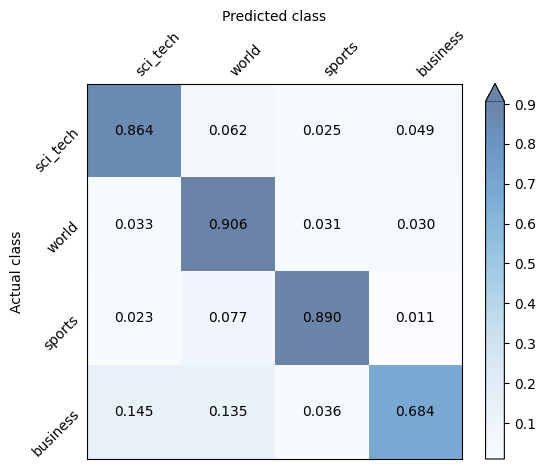

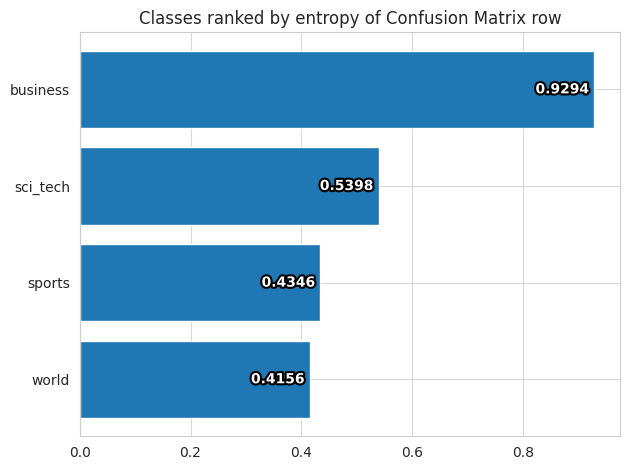

In [12]:
# Visualizes confusion matrix, which gives an overview of classifier performance
# for each class.
from ludwig.visualize import confusion_matrix

confusion_matrix(
  [test_stats],
  model.training_set_metadata,
  'class',
  top_n_classes=[5],
  model_names=[''],
  normalize=True,
)

In [7]:
import pandas as pd

text_to_predict = pd.DataFrame({
  "title": [
    "Google may spur cloud cybersecurity M&A with $5.4B Mandiant buy",
    "Europe struggles to meet mounting needs of Ukraine's fleeing millions",
    "How the pandemic housing market spurred buyer's remorse across America",
  ]
})

predictions, output_directory = model.predict(text_to_predict)

predictions

Prediction: 100%|██████████| 1/1 [00:00<00:00, 83.21it/s]


,class_predictions,class_probabilities,class_probability,class_probabilities_sci_tech,class_probabilities_world,class_probabilities_sports,class_probabilities_business
0,business,"[0.3130781948566437, 0.00023208462516777217, 3...",0.686654,0.313078,0.000232,0.000036,0.686654
1,world,"[0.0031794668175280094, 0.9947161078453064, 0....",0.994716,0.003179,0.994716,0.000799,0.001306
2,sci_tech,"[0.563317596912384, 0.06807877868413925, 5.902...",0.563318,0.563318,0.068079,0.000059,0.368545
